In [1]:
! pip install matplotlib opencv-python pandas numpy seaborn tqdm scikit-learn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision import models
import torchvision

import numpy as np
import matplotlib.pyplot as plt


In [3]:
# helper function
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize=(5, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


<h1> Prepare Data</h1>

In [24]:
from datasetv2 import datasetv3
from ad_labels import LABELS_MAP, LABELS_LIST

batch_size = 128
train_loader, test_loader, train_dataset, test_dataset = datasetv3()

100%|██████████| 4/4 [00:00<00:00, 157.03it/s]


In [6]:
# dataiter = iter(train_loader)
for i, (images, labels) in enumerate(train_loader):
    break
print(type(images))
print(images.shape)
print(labels.shape)
print(type(train_loader))

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<class 'torch.Tensor'>
torch.Size([128, 3, 299, 299])
torch.Size([128])
<class 'torch.utils.data.dataloader.DataLoader'>


# Inceptionv3

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

model = models.inception_v3(pretrained=True)
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False

# model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 10), nn.Linear(10, 2))
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 4))

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)

num_epochs = 15
losses = []
steppedloss = []
class3acclist = []
totalacc = []
mdtotal = 0
mdcorrect = 0

for epoch in range(num_epochs):
    total_batch = len(train_dataset) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.to(device)
        Y = batch_labels.to(device)
        
        pre = model(X)
        cost = loss(pre, Y)
            
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(pre.data, 1) # get predicted values for error

        if (i + 1) % 5 == 0:
            losses.append(cost.item())
            print(
                "Epoch [%d/%d], lter [%d/%d] Loss: %.4f"
                % (epoch + 1, num_epochs, i + 1, total_batch, cost.item())
            )
        
        mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted])
        mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
        mdcorrect += (mdpreds == batch_labels).sum().item()

    class3acc = mdcorrect/mdtotal
    
    class_report = classification_report(batch_labels, predicted.cpu(), target_names=LABELS_LIST, output_dict=True)
    print(f"Epoch {num_epochs}, Accuracy: {class_report['accuracy']}, Lbl3 Acc: {class3acc}")
    
    class3acclist.append(class3acc)
    steppedloss.append(cost.item())
    totalacc.append(class_report['accuracy'])
    predicted = predicted.cpu()

print(classification_report(batch_labels, predicted.cpu(), target_names=LABELS_LIST))

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chong\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialia

Epoch [1/15], lter [5/40] Loss: 1.3706
Epoch [1/15], lter [10/40] Loss: 1.3182
Epoch [1/15], lter [15/40] Loss: 1.2833
Epoch [1/15], lter [20/40] Loss: 1.2500
Epoch [1/15], lter [25/40] Loss: 1.1461
Epoch [1/15], lter [30/40] Loss: 1.0708
Epoch [1/15], lter [35/40] Loss: 1.1283
Epoch [1/15], lter [40/40] Loss: 1.0178
Epoch 15, Accuracy: 0.59375, Lbl3 Acc: 0.5931612002791347


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [2/15], lter [5/40] Loss: 1.0448
Epoch [2/15], lter [10/40] Loss: 1.0444
Epoch [2/15], lter [15/40] Loss: 1.0097
Epoch [2/15], lter [20/40] Loss: 0.9749
Epoch [2/15], lter [25/40] Loss: 1.0335
Epoch [2/15], lter [30/40] Loss: 0.9751
Epoch [2/15], lter [35/40] Loss: 1.0191
Epoch [2/15], lter [40/40] Loss: 0.9739
Epoch 15, Accuracy: 0.6015625, Lbl3 Acc: 0.6931497175141242


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [3/15], lter [5/40] Loss: 0.9854
Epoch [3/15], lter [10/40] Loss: 0.9323
Epoch [3/15], lter [15/40] Loss: 0.8877
Epoch [3/15], lter [20/40] Loss: 0.8717
Epoch [3/15], lter [25/40] Loss: 0.8357
Epoch [3/15], lter [30/40] Loss: 0.9712
Epoch [3/15], lter [35/40] Loss: 0.8779
Epoch [3/15], lter [40/40] Loss: 0.9905
Epoch 15, Accuracy: 0.578125, Lbl3 Acc: 0.7487661574618096


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [4/15], lter [5/40] Loss: 0.8839
Epoch [4/15], lter [10/40] Loss: 0.8667
Epoch [4/15], lter [15/40] Loss: 0.9411
Epoch [4/15], lter [20/40] Loss: 0.9352
Epoch [4/15], lter [25/40] Loss: 0.8509
Epoch [4/15], lter [30/40] Loss: 0.8657
Epoch [4/15], lter [35/40] Loss: 0.7608
Epoch [4/15], lter [40/40] Loss: 0.9159
Epoch 15, Accuracy: 0.609375, Lbl3 Acc: 0.7775431186202042


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [5/15], lter [5/40] Loss: 0.8133
Epoch [5/15], lter [10/40] Loss: 0.8084
Epoch [5/15], lter [15/40] Loss: 0.8271
Epoch [5/15], lter [20/40] Loss: 0.8650
Epoch [5/15], lter [25/40] Loss: 0.8412
Epoch [5/15], lter [30/40] Loss: 0.8746
Epoch [5/15], lter [35/40] Loss: 0.8163
Epoch [5/15], lter [40/40] Loss: 0.8560
Epoch 15, Accuracy: 0.640625, Lbl3 Acc: 0.7955280551258613


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [6/15], lter [5/40] Loss: 0.7315
Epoch [6/15], lter [10/40] Loss: 0.7340
Epoch [6/15], lter [15/40] Loss: 0.8614
Epoch [6/15], lter [20/40] Loss: 0.8281
Epoch [6/15], lter [25/40] Loss: 0.7604
Epoch [6/15], lter [30/40] Loss: 0.8331
Epoch [6/15], lter [35/40] Loss: 0.7845
Epoch [6/15], lter [40/40] Loss: 0.7520
Epoch 15, Accuracy: 0.671875, Lbl3 Acc: 0.8107949888771807


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [7/15], lter [5/40] Loss: 0.8185
Epoch [7/15], lter [10/40] Loss: 0.7717
Epoch [7/15], lter [15/40] Loss: 0.7582
Epoch [7/15], lter [20/40] Loss: 0.7478
Epoch [7/15], lter [25/40] Loss: 0.7548
Epoch [7/15], lter [30/40] Loss: 0.7291
Epoch [7/15], lter [35/40] Loss: 0.8193
Epoch [7/15], lter [40/40] Loss: 0.7542
Epoch 15, Accuracy: 0.671875, Lbl3 Acc: 0.8223564954682779


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [8/15], lter [5/40] Loss: 0.7171
Epoch [8/15], lter [10/40] Loss: 0.6898
Epoch [8/15], lter [15/40] Loss: 0.7785
Epoch [8/15], lter [20/40] Loss: 0.7599
Epoch [8/15], lter [25/40] Loss: 0.7553
Epoch [8/15], lter [30/40] Loss: 0.7788
Epoch [8/15], lter [35/40] Loss: 0.7152
Epoch [8/15], lter [40/40] Loss: 0.8259
Epoch 15, Accuracy: 0.625, Lbl3 Acc: 0.8321425421187263


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [9/15], lter [5/40] Loss: 0.7734
Epoch [9/15], lter [10/40] Loss: 0.7837
Epoch [9/15], lter [15/40] Loss: 0.7940
Epoch [9/15], lter [20/40] Loss: 0.7263
Epoch [9/15], lter [25/40] Loss: 0.6692
Epoch [9/15], lter [30/40] Loss: 0.7394
Epoch [9/15], lter [35/40] Loss: 0.7518
Epoch [9/15], lter [40/40] Loss: 0.7829
Epoch 15, Accuracy: 0.6796875, Lbl3 Acc: 0.8391448406437362


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [10/15], lter [5/40] Loss: 0.7046
Epoch [10/15], lter [10/40] Loss: 0.6949
Epoch [10/15], lter [15/40] Loss: 0.7700
Epoch [10/15], lter [20/40] Loss: 0.7920
Epoch [10/15], lter [25/40] Loss: 0.6970
Epoch [10/15], lter [30/40] Loss: 0.7569
Epoch [10/15], lter [35/40] Loss: 0.8278
Epoch [10/15], lter [40/40] Loss: 0.8262
Epoch 15, Accuracy: 0.578125, Lbl3 Acc: 0.8458312602174994


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [11/15], lter [5/40] Loss: 0.7439
Epoch [11/15], lter [10/40] Loss: 0.7633
Epoch [11/15], lter [15/40] Loss: 0.7744
Epoch [11/15], lter [20/40] Loss: 0.8106
Epoch [11/15], lter [25/40] Loss: 0.7194
Epoch [11/15], lter [30/40] Loss: 0.7300
Epoch [11/15], lter [35/40] Loss: 0.7417
Epoch [11/15], lter [40/40] Loss: 0.6870
Epoch 15, Accuracy: 0.7421875, Lbl3 Acc: 0.8508054040010392


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [12/15], lter [5/40] Loss: 0.7346
Epoch [12/15], lter [10/40] Loss: 0.8009
Epoch [12/15], lter [15/40] Loss: 0.8005
Epoch [12/15], lter [20/40] Loss: 0.6997
Epoch [12/15], lter [25/40] Loss: 0.6973
Epoch [12/15], lter [30/40] Loss: 0.7795
Epoch [12/15], lter [35/40] Loss: 0.8525
Epoch [12/15], lter [40/40] Loss: 0.7545
Epoch 15, Accuracy: 0.6953125, Lbl3 Acc: 0.8556308716850993


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [13/15], lter [5/40] Loss: 0.7203
Epoch [13/15], lter [10/40] Loss: 0.6923
Epoch [13/15], lter [15/40] Loss: 0.7998
Epoch [13/15], lter [20/40] Loss: 0.6604
Epoch [13/15], lter [25/40] Loss: 0.7283
Epoch [13/15], lter [30/40] Loss: 0.6487
Epoch [13/15], lter [35/40] Loss: 0.6589
Epoch [13/15], lter [40/40] Loss: 0.7193
Epoch 15, Accuracy: 0.703125, Lbl3 Acc: 0.8614030261348006


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [14/15], lter [5/40] Loss: 0.6385
Epoch [14/15], lter [10/40] Loss: 0.6892
Epoch [14/15], lter [15/40] Loss: 0.7554
Epoch [14/15], lter [20/40] Loss: 0.7145
Epoch [14/15], lter [25/40] Loss: 0.6488
Epoch [14/15], lter [30/40] Loss: 0.6861
Epoch [14/15], lter [35/40] Loss: 0.6999
Epoch [14/15], lter [40/40] Loss: 0.7150
Epoch 15, Accuracy: 0.71875, Lbl3 Acc: 0.8648910658707077


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [15/15], lter [5/40] Loss: 0.6787
Epoch [15/15], lter [10/40] Loss: 0.7999
Epoch [15/15], lter [15/40] Loss: 0.8409
Epoch [15/15], lter [20/40] Loss: 0.6004
Epoch [15/15], lter [25/40] Loss: 0.8215
Epoch [15/15], lter [30/40] Loss: 0.7187
Epoch [15/15], lter [35/40] Loss: 0.7792
Epoch [15/15], lter [40/40] Loss: 0.7218
Epoch 15, Accuracy: 0.6875, Lbl3 Acc: 0.8682689091690955
                    precision    recall  f1-score   support

      Non_Demented       0.71      0.56      0.63        27
Very_Mild_Demented       0.49      0.59      0.53        34
     Mild_Demented       0.69      0.63      0.66        38
 Moderate_Demented       0.94      1.00      0.97        29

          accuracy                           0.69       128
         macro avg       0.71      0.69      0.70       128
      weighted avg       0.70      0.69      0.69       128



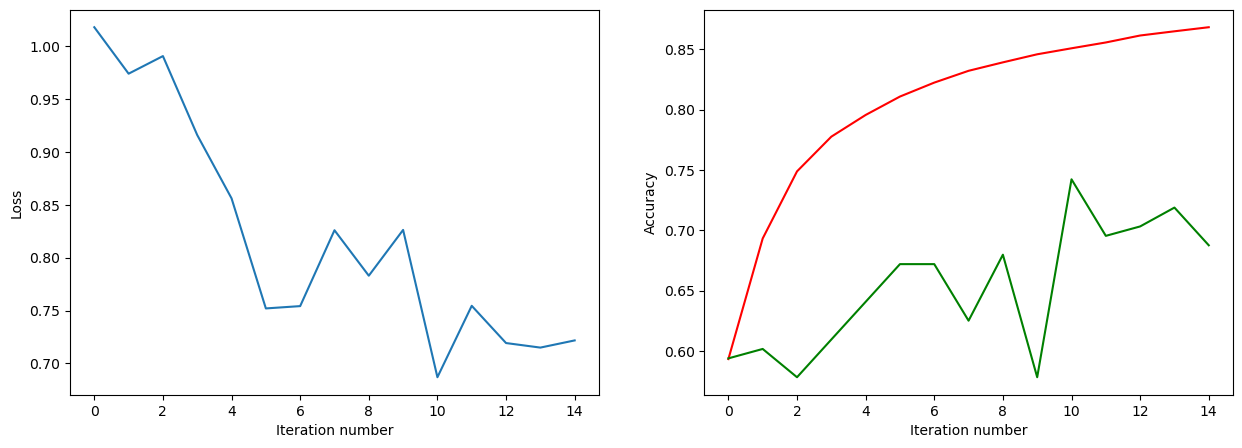

In [8]:
# plot losses

# Initialize matplotlib
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].plot(list(range(len(steppedloss))), steppedloss)
axs[0].set_xlabel("Iteration number")
axs[0].set_ylabel("Loss")
# axs[1].plot(list(range(len(steppedloss))), steppedloss)
# axs[1].set_xlabel("Iteration number")
# axs[1].set_ylabel("Loss (in logarithmic scale)")
# axs[1].set_yscale("log")

axs[1].plot(list(range(len(class3acclist))), class3acclist,'-r', label="lbl3_accuracy")
axs[1].plot(list(range(len(totalacc))), totalacc,'-g', label="total_accuracy")
axs[1].set_xlabel("Iteration number")
axs[1].set_ylabel("Accuracy")

# Display
plt.show()

In [9]:
# import ad_labels
# model = torch.load('inceptionv3v3.pt')

model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    images = images.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum()

    mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted])
    mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
    mdcorrect += (mdpreds == labels).sum().item()

class3acc = mdcorrect/mdtotal

class_report = classification_report(labels, predicted.cpu(), target_names=LABELS_LIST, output_dict=True)
print(f"Epoch {num_epochs}, Accuracy: {class_report['accuracy']}, Lbl3 Acc: {class3acc}")

class3acclist.append(class3acc)
steppedloss.append(cost.item())
totalacc.append(class_report['accuracy'])
predicted = predicted.cpu()

print(classification_report(labels.cpu(), predicted.cpu(), target_names=LABELS_LIST))

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 15, Accuracy: 0.625, Lbl3 Acc: 0.8694974494615529
                    precision    recall  f1-score   support

      Non_Demented       0.83      0.50      0.62        30
Very_Mild_Demented       0.48      0.65      0.55        31
     Mild_Demented       0.51      0.66      0.57        35
 Moderate_Demented       0.96      0.69      0.80        32

          accuracy                           0.62       128
         macro avg       0.69      0.62      0.64       128
      weighted avg       0.69      0.62      0.64       128



In [10]:
torch.save(model, 'inceptionv3_standard_0.pt')

v1: lr 1e-3, 10, batch_siz = 128 epochs 58.046875 %
v2: lr 5e-4, 15, batch_siz = 128 epochs 57.968750 %
v3: lr 1e-3, 15, batch_siz = 128 epochs 58.359375 %
v4: lr 1e-3, 15, batch_siz = 64 epochs 58.125000 %
v5: lr 1e-3, 15, batch_siz = 256 epochs 60.468750 %
v6: lr 1e-3, 15, batch_siz = 512 epochs 56.328125 %


# Inceptionv3 with Batch normalization
Attempt to counter overfitting by generalizing the model more.

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

model = models.inception_v3(pretrained=True)
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False
    
for name, module in model.named_children():
    if isinstance(module, nn.Conv2d):
        # Insert BatchNorm layer after each Conv2d layer
        setattr(model, name, nn.Sequential(module, nn.BatchNorm2d(module.out_channels)))



# model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 10), nn.Linear(10, 2))
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 4))

model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4
)

# print(model.eval())
num_epochs = 15
losses = []
steppedloss = []
class3acclist = []
totalacc = []
mdtotal = 0
mdcorrect = 0
cap = []
lowestcost = float('inf')
for epoch in range(num_epochs):
    total_batch = len(train_dataset) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.to(device)
        Y = batch_labels.to(device)

        pre = model(X)
        cost = loss(pre, Y)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(pre.data, 1) # get predicted values for error

        if (i + 1) % 5 == 0:
            losses.append(cost.item())
            print(
                "Epoch [%d/%d], lter [%d/%d] Loss: %.4f"
                % (epoch + 1, num_epochs, i + 1, total_batch, cost.item())
            )
        
        mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted])
        mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
        mdcorrect += (mdpreds == batch_labels).sum().item()

    class3acc = mdcorrect/mdtotal
    
    class_report = classification_report(batch_labels, predicted.cpu(), target_names=LABELS_LIST, output_dict=True)
    print(f"Epoch {num_epochs}, Accuracy: {class_report['accuracy']}, Lbl3 Acc: {class3acc}")
    
    class3acclist.append(class3acc)
    steppedloss.append(cost.item())
    totalacc.append(class_report['accuracy'])
    predicted = predicted.cpu()

print(classification_report(batch_labels, predicted.cpu(), target_names=LABELS_LIST))

# Save the captured output to a text file
# with open('inceptionv3batchnormv3.txt', 'w') as file:
    # file.write(i for i in stdoutput)


Epoch [1/15], lter [5/40] Loss: 1.3387
Epoch [1/15], lter [10/40] Loss: 1.2721
Epoch [1/15], lter [15/40] Loss: 1.2118
Epoch [1/15], lter [20/40] Loss: 1.1371
Epoch [1/15], lter [25/40] Loss: 1.1333
Epoch [1/15], lter [30/40] Loss: 1.1386
Epoch [1/15], lter [35/40] Loss: 1.0556
Epoch [1/15], lter [40/40] Loss: 1.0419
Epoch 15, Accuracy: 0.5625, Lbl3 Acc: 0.6791666666666667


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [2/15], lter [5/40] Loss: 0.9299
Epoch [2/15], lter [10/40] Loss: 1.0183
Epoch [2/15], lter [15/40] Loss: 1.0292
Epoch [2/15], lter [20/40] Loss: 1.0139
Epoch [2/15], lter [25/40] Loss: 1.0694
Epoch [2/15], lter [30/40] Loss: 0.9762
Epoch [2/15], lter [35/40] Loss: 0.9697
Epoch [2/15], lter [40/40] Loss: 0.9314
Epoch 15, Accuracy: 0.609375, Lbl3 Acc: 0.7410344827586207


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [3/15], lter [5/40] Loss: 0.8770
Epoch [3/15], lter [10/40] Loss: 0.9725
Epoch [3/15], lter [15/40] Loss: 0.9178
Epoch [3/15], lter [20/40] Loss: 0.9092
Epoch [3/15], lter [25/40] Loss: 0.8467
Epoch [3/15], lter [30/40] Loss: 0.8327
Epoch [3/15], lter [35/40] Loss: 0.9129
Epoch [3/15], lter [40/40] Loss: 0.9671
Epoch 15, Accuracy: 0.546875, Lbl3 Acc: 0.7801484230055659


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [4/15], lter [5/40] Loss: 0.9205
Epoch [4/15], lter [10/40] Loss: 0.8244
Epoch [4/15], lter [15/40] Loss: 0.9444
Epoch [4/15], lter [20/40] Loss: 0.9353
Epoch [4/15], lter [25/40] Loss: 0.9352
Epoch [4/15], lter [30/40] Loss: 0.9149
Epoch [4/15], lter [35/40] Loss: 0.9049
Epoch [4/15], lter [40/40] Loss: 0.7609
Epoch 15, Accuracy: 0.6640625, Lbl3 Acc: 0.7983266515600488


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [5/15], lter [5/40] Loss: 0.7318
Epoch [5/15], lter [10/40] Loss: 0.8086
Epoch [5/15], lter [15/40] Loss: 0.8212
Epoch [5/15], lter [20/40] Loss: 0.7974
Epoch [5/15], lter [25/40] Loss: 0.8867
Epoch [5/15], lter [30/40] Loss: 0.8185
Epoch [5/15], lter [35/40] Loss: 0.8247
Epoch [5/15], lter [40/40] Loss: 0.7972
Epoch 15, Accuracy: 0.640625, Lbl3 Acc: 0.8133146461107218


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [6/15], lter [5/40] Loss: 0.8632
Epoch [6/15], lter [10/40] Loss: 0.8617
Epoch [6/15], lter [15/40] Loss: 0.8771
Epoch [6/15], lter [20/40] Loss: 0.7975
Epoch [6/15], lter [25/40] Loss: 0.8179
Epoch [6/15], lter [30/40] Loss: 0.8159
Epoch [6/15], lter [35/40] Loss: 0.8098
Epoch [6/15], lter [40/40] Loss: 0.7239
Epoch 15, Accuracy: 0.65625, Lbl3 Acc: 0.8244940683879972


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [7/15], lter [5/40] Loss: 0.6655
Epoch [7/15], lter [10/40] Loss: 0.8352
Epoch [7/15], lter [15/40] Loss: 0.7980
Epoch [7/15], lter [20/40] Loss: 0.7786
Epoch [7/15], lter [25/40] Loss: 0.7838
Epoch [7/15], lter [30/40] Loss: 0.7594
Epoch [7/15], lter [35/40] Loss: 0.6958
Epoch [7/15], lter [40/40] Loss: 0.7432
Epoch 15, Accuracy: 0.6875, Lbl3 Acc: 0.8339853545992577


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [8/15], lter [5/40] Loss: 0.7510
Epoch [8/15], lter [10/40] Loss: 0.7711
Epoch [8/15], lter [15/40] Loss: 0.7779
Epoch [8/15], lter [20/40] Loss: 0.7450
Epoch [8/15], lter [25/40] Loss: 0.7725
Epoch [8/15], lter [30/40] Loss: 0.7815
Epoch [8/15], lter [35/40] Loss: 0.7584
Epoch [8/15], lter [40/40] Loss: 0.7354
Epoch 15, Accuracy: 0.6796875, Lbl3 Acc: 0.842271848074556


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [9/15], lter [5/40] Loss: 0.8505
Epoch [9/15], lter [10/40] Loss: 0.8535
Epoch [9/15], lter [15/40] Loss: 0.7544
Epoch [9/15], lter [20/40] Loss: 0.8061
Epoch [9/15], lter [25/40] Loss: 0.7564
Epoch [9/15], lter [30/40] Loss: 0.8492
Epoch [9/15], lter [35/40] Loss: 0.7222
Epoch [9/15], lter [40/40] Loss: 0.7246
Epoch 15, Accuracy: 0.6640625, Lbl3 Acc: 0.848180677540778


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [10/15], lter [5/40] Loss: 0.7110
Epoch [10/15], lter [10/40] Loss: 0.7200
Epoch [10/15], lter [15/40] Loss: 0.7603
Epoch [10/15], lter [20/40] Loss: 0.7887
Epoch [10/15], lter [25/40] Loss: 0.6878
Epoch [10/15], lter [30/40] Loss: 0.7037
Epoch [10/15], lter [35/40] Loss: 0.8485
Epoch [10/15], lter [40/40] Loss: 0.7877
Epoch 15, Accuracy: 0.65625, Lbl3 Acc: 0.8537398085785183


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [11/15], lter [5/40] Loss: 0.7364
Epoch [11/15], lter [10/40] Loss: 0.7685
Epoch [11/15], lter [15/40] Loss: 0.7970
Epoch [11/15], lter [20/40] Loss: 0.7819
Epoch [11/15], lter [25/40] Loss: 0.6633
Epoch [11/15], lter [30/40] Loss: 0.8373
Epoch [11/15], lter [35/40] Loss: 0.8013
Epoch [11/15], lter [40/40] Loss: 0.7580
Epoch 15, Accuracy: 0.6640625, Lbl3 Acc: 0.8582152332880347


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [12/15], lter [5/40] Loss: 0.6691
Epoch [12/15], lter [10/40] Loss: 0.7217
Epoch [12/15], lter [15/40] Loss: 0.7262
Epoch [12/15], lter [20/40] Loss: 0.5991
Epoch [12/15], lter [25/40] Loss: 0.7337
Epoch [12/15], lter [30/40] Loss: 0.8153
Epoch [12/15], lter [35/40] Loss: 0.8092
Epoch [12/15], lter [40/40] Loss: 0.6844
Epoch 15, Accuracy: 0.7109375, Lbl3 Acc: 0.862538662859862


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [13/15], lter [5/40] Loss: 0.7299
Epoch [13/15], lter [10/40] Loss: 0.6830
Epoch [13/15], lter [15/40] Loss: 0.7632
Epoch [13/15], lter [20/40] Loss: 0.8152
Epoch [13/15], lter [25/40] Loss: 0.7153
Epoch [13/15], lter [30/40] Loss: 0.7202
Epoch [13/15], lter [35/40] Loss: 0.6622
Epoch [13/15], lter [40/40] Loss: 0.8248
Epoch 15, Accuracy: 0.5859375, Lbl3 Acc: 0.8668026011242147


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [14/15], lter [5/40] Loss: 0.6934
Epoch [14/15], lter [10/40] Loss: 0.7795
Epoch [14/15], lter [15/40] Loss: 0.7383
Epoch [14/15], lter [20/40] Loss: 0.8628
Epoch [14/15], lter [25/40] Loss: 0.6722
Epoch [14/15], lter [30/40] Loss: 0.6338
Epoch [14/15], lter [35/40] Loss: 0.7315
Epoch [14/15], lter [40/40] Loss: 0.7022
Epoch 15, Accuracy: 0.6875, Lbl3 Acc: 0.8702973844500179


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [15/15], lter [5/40] Loss: 0.6599
Epoch [15/15], lter [10/40] Loss: 0.7538
Epoch [15/15], lter [15/40] Loss: 0.8700
Epoch [15/15], lter [20/40] Loss: 0.6588
Epoch [15/15], lter [25/40] Loss: 0.6344
Epoch [15/15], lter [30/40] Loss: 0.6921
Epoch [15/15], lter [35/40] Loss: 0.6999
Epoch [15/15], lter [40/40] Loss: 0.6679
Epoch 15, Accuracy: 0.7265625, Lbl3 Acc: 0.8738170347003155
                    precision    recall  f1-score   support

      Non_Demented       0.85      0.67      0.75        33
Very_Mild_Demented       0.66      0.53      0.58        36
     Mild_Demented       0.53      0.84      0.65        25
 Moderate_Demented       0.94      0.91      0.93        34

          accuracy                           0.73       128
         macro avg       0.74      0.74      0.73       128
      weighted avg       0.75      0.73      0.73       128



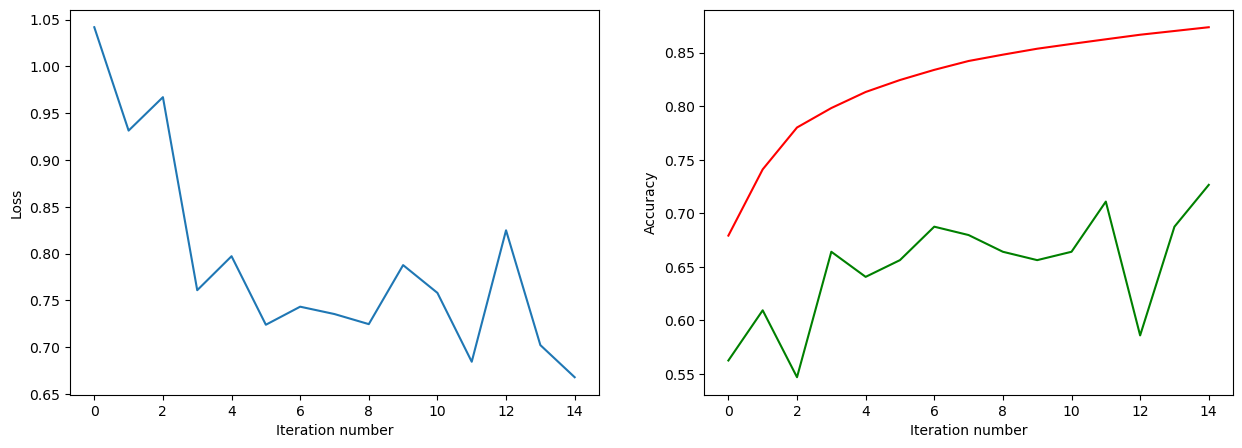

In [26]:
# plot losses

# Initialize matplotlib
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].plot(list(range(len(steppedloss))), steppedloss)
axs[0].set_xlabel("Iteration number")
axs[0].set_ylabel("Loss")
# axs[1].plot(list(range(len(steppedloss))), steppedloss)
# axs[1].set_xlabel("Iteration number")
# axs[1].set_ylabel("Loss (in logarithmic scale)")
# axs[1].set_yscale("log")

axs[1].plot(list(range(len(class3acclist))), class3acclist,'-r', label="lbl3_accuracy")
axs[1].plot(list(range(len(totalacc))), totalacc,'-g', label="total_accuracy")
axs[1].set_xlabel("Iteration number")
axs[1].set_ylabel("Accuracy")

# Display
plt.show()

In [27]:
# import ad_labels
# model = torch.load('inceptionv3v3.pt')

model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    images = images.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum()

    mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted])
    mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
    mdcorrect += (mdpreds == labels).sum().item()

class3acc = mdcorrect/mdtotal

class_report = classification_report(labels, predicted.cpu(), target_names=LABELS_LIST, output_dict=True)
print(f"Epoch {num_epochs}, Accuracy: {class_report['accuracy']}, Lbl3 Acc: {class3acc}")

class3acclist.append(class3acc)
steppedloss.append(cost.item())
totalacc.append(class_report['accuracy'])
predicted = predicted.cpu()

print(classification_report(labels, predicted.cpu(), target_names=LABELS_LIST))

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 15, Accuracy: 0.6796875, Lbl3 Acc: 0.8749705007787795
                    precision    recall  f1-score   support

      Non_Demented       0.28      0.21      0.24        33
Very_Mild_Demented       0.26      0.28      0.27        36
     Mild_Demented       0.30      0.36      0.33        25
 Moderate_Demented       0.29      0.29      0.29        34

          accuracy                           0.28       128
         macro avg       0.28      0.29      0.28       128
      weighted avg       0.28      0.28      0.28       128



In [28]:
torch.save(model, 'inceptionv3_batchnorm_0.pt')

# Standard 2 Layer CNN Model 
Model was still severely overfitting. We decided to decrease the size of the model making it a 2 layer network.

In [29]:
import torch.optim as optim
from datasetv3 import datasetv4

def train(model, train_loader, epochs = 10, lr = 0.001):
    # Use Adam optimizer to update model weights
    optimizer = optim.Adam(model.parameters(), lr = lr)
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    train_losses = []
    train_accuracies = []

    # num_epochs = 15
    # steppedloss = []
    # totalacc = []
    class3acclist = []
    mdtotal = 0
    mdcorrect = 0
    
    model = model.to(device)

    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (batch_number + 1) % 5 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
                
            
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')

        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0

        mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted]).to(device)
        mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
        mdcorrect += (mdpreds == labels).sum().item()
    
        class3acc = mdcorrect/mdtotal
        
        # class_report = classification_report(batch_labels, predicted.cpu(), target_names=LABELS_LIST, output_dict=True)
        # print(f"Epoch {num_epochs}, Accuracy: {class_report['accuracy']}, Lbl3 Acc: {class3acc}")
        
        class3acclist.append(class3acc)
        # steppedloss.append(cost.item())
        # totalacc.append(class_report['accuracy'])
        predicted = predicted.cpu()
            
    print(classification_report(labels.cpu(), predicted.cpu(), target_names=LABELS_LIST))
    return train_losses, train_accuracies, class3acclist


In [49]:
# Iterate over test data
def test(model, test_loader, epochs = 10, lr = 0.001):
    test_losses = []
    test_accuracies = []
    criterion = nn.CrossEntropyLoss()

    # steppedloss = []
    # totalacc = []
    class3acclist = []
    mdtotal = 0
    mdcorrect = 0
    epoch_loss = 0
    total = 0
    correct = 0
    
    
    for inputs, labels in test_loader:
        # Get from dataloader and send to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Compute model output and loss
        # (No grad computation here, as it is the test data)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
        # Accumulate loss and correct predictions for epoch
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        mdpreds = torch.FloatTensor([3 if pred == 3 else 4 for pred in predicted]).to(device)
        mdtotal += sum([1 if pred == 3 else 0 for pred in predicted])
        mdcorrect += (mdpreds == labels).sum().item()
    
        class3acc = mdcorrect/mdtotal
        class3acclist.append(class3acc)
        # predicted = predicted.cpu()
            
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
    
    print(classification_report(labels.cpu(), predicted.cpu(), target_names=LABELS_LIST))

    return test_losses, test_accuracies, class3acclist

In [38]:
# standard convolution model
class Az_CNN(nn.Module):
  def __init__(self):
    super(Az_CNN, self).__init__()
    # two convolutional layers
    self.conv1 = nn.Conv2d(3,32, kernel_size=3, stride=1, padding=1 )
    self.conv2 = nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1)

    # two fully connected layers
    self.fc1 = nn.Linear(28*28*64, 128) # 28*28*3 = 50176 # [128, 224, 224, 3]
    self.fc2 = nn.Linear(128, 4)

  def forward(self, x):
      
      x = self.conv1(x)
      x = F.relu(x)
    
      x = self.conv2(x)
      x = F.relu(x)

      # Flatten output of second conv layer
      x = x.view(-1, 28*28*64)
      # Pass flattened output through first Linear layer
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      return x


In [65]:
model = Az_CNN().to(device)
model.eval()

Az_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [66]:
train_loader, test_loader, train_dataset, test_dataset = datasetv4()

100%|██████████| 4/4 [00:00<00:00, 140.55it/s]


In [67]:
train_losses, train_accuracies, class3acclist = train(model, train_loader, epochs = 13, lr = 1e-3)

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/13, Batch number: 4, Cumulated accuracy: 0.2859375
Epoch 1/13, Batch number: 9, Cumulated accuracy: 0.28046875
Epoch 1/13, Batch number: 14, Cumulated accuracy: 0.2942708333333333
Epoch 1/13, Batch number: 19, Cumulated accuracy: 0.327734375
Epoch 1/13, Batch number: 24, Cumulated accuracy: 0.36625
Epoch 1/13, Batch number: 29, Cumulated accuracy: 0.39427083333333335
Epoch 1/13, Batch number: 34, Cumulated accuracy: 0.41875
Epoch 1/13, Batch number: 39, Cumulated accuracy: 0.4404296875
--- Epoch 1/13: Train loss: 1.4241, Train accuracy: 0.4404
Epoch 2/13, Batch number: 4, Cumulated accuracy: 0.59375
Epoch 2/13, Batch number: 9, Cumulated accuracy: 0.62421875
Epoch 2/13, Batch number: 14, Cumulated accuracy: 0.6359375
Epoch 2/13, Batch number: 19, Cumulated accuracy: 0.652734375
Epoch 2/13, Batch number: 24, Cumulated accuracy: 0.65375
Epoch 2/13, Batch number: 29, Cumulated accuracy: 0.6578125
Epoch 2/13, Batch number: 34, Cumulated accuracy: 0.6642857142857143
Epoch 2/13, Batc

In [68]:
# Label 3 final accuracy
print(class3acclist[-1])

0.9977272727272727


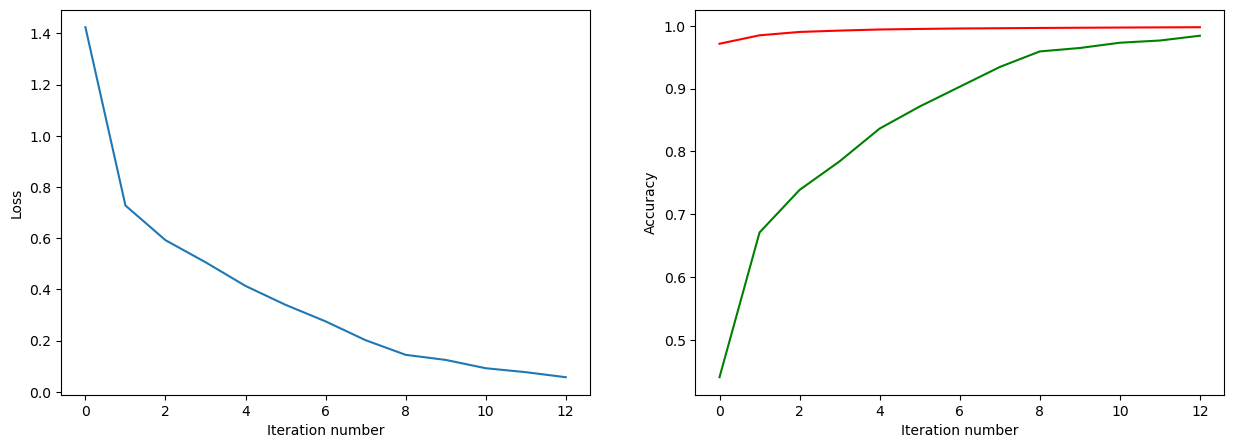

In [69]:
# plot losses

# Initialize matplotlib
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].plot(list(range(len(train_losses))), train_losses)
axs[0].set_xlabel("Iteration number")
axs[0].set_ylabel("Loss")
# axs[1].plot(list(range(len(steppedloss))), steppedloss)
# axs[1].set_xlabel("Iteration number")
# axs[1].set_ylabel("Loss (in logarithmic scale)")
# axs[1].set_yscale("log")

axs[1].plot(list(range(len(class3acclist))), class3acclist,'-r', label="lbl3_accuracy")
axs[1].plot(list(range(len(train_accuracies))), train_accuracies,'-g', label="train_accuracies")
axs[1].set_xlabel("Iteration number")
axs[1].set_ylabel("Accuracy")

# Display
plt.show()

In [70]:
test_losses, test_accuracies, class3acclist = test(model, \
                                                                     test_loader, \
                                                                     epochs = 1, \
                                                                     lr = 1e-3)

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


--- Epoch 15/1: Test loss: 0.0086, Test accuracy: 0.9844
--- Epoch 15/1: Test loss: 0.0081, Test accuracy: 0.9805
--- Epoch 15/1: Test loss: 0.0218, Test accuracy: 0.9609
--- Epoch 15/1: Test loss: 0.0288, Test accuracy: 0.9570
--- Epoch 15/1: Test loss: 0.0137, Test accuracy: 0.9578
--- Epoch 15/1: Test loss: 0.0180, Test accuracy: 0.9570
--- Epoch 15/1: Test loss: 0.0133, Test accuracy: 0.9598
--- Epoch 15/1: Test loss: 0.0119, Test accuracy: 0.9580
--- Epoch 15/1: Test loss: 0.0104, Test accuracy: 0.9609
--- Epoch 15/1: Test loss: 0.0099, Test accuracy: 0.9625
                    precision    recall  f1-score   support

      Non_Demented       0.96      0.93      0.95        28
Very_Mild_Demented       0.95      0.97      0.96        38
     Mild_Demented       1.00      1.00      1.00        29
 Moderate_Demented       1.00      1.00      1.00        33

          accuracy                           0.98       128
         macro avg       0.98      0.98      0.98       128
      we

In [71]:
torch.save(model, 'stdCNN.pt')